In [146]:
import time
import sqlite3
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report  #conf matrix
import seaborn as sns #conf matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from time import time
import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score

#from utils import mean_absolute_percentage_error

# LOAD DATA

In [147]:
cn = sqlite3.connect('../laliga.sqlite')
df = pd.read_sql_query("SELECT * FROM Matches", cn)
df_aux = df
df_aux

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2
...,...,...,...,...,...,...,...,...
49015,2021-2022,2,42,5/29/22,None,Real Oviedo,UD Ibiza,None
49016,2021-2022,2,42,5/29/22,None,Real Sociedad B,Real Zaragoza,None
49017,2021-2022,2,42,5/29/22,None,Sporting Gijón,UD Las Palmas,None
49018,2021-2022,2,42,5/29/22,None,CD Tenerife,FC Cartagena,None


## NEW FEATURES

In [148]:
def parse_score(score):
    w = ''
    if score:
        score = score.split(':')
        if score[0] > score[1]:
            w = 1
        elif score[0] < score[1]:
            w = 2
        elif score[0] == score[1]:
            w = 0
    else:
        w = 'Unknown'
    return w

# Match results
scores = df_aux['score'].values
scores = [x.split(':') if x else [-1, -1] for x in scores]
df_aux['Result'] = df_aux['score'].apply(parse_score)

In [149]:
#Home goals and away goals
home_goals = []
away_goals = []
for scored_goals in scores:
    home_goals.append(scored_goals[0])
    away_goals.append(scored_goals[1])
df_aux['home_goals'] = pd.to_numeric(home_goals)
df_aux['away_goals'] = pd.to_numeric(away_goals)
# Goal difference
df_aux['goal_difference'] = abs(df_aux['home_goals'] - df_aux['away_goals'])
df_aux['total_goals'] = df_aux['home_goals'] + df_aux['away_goals']

In [150]:
#Assigning values to each time in order of aparison
teams = df_aux['home_team'].drop_duplicates().values
df_aux['home_id'] = 0
df_aux['away_id'] = 0
df_aux
for i in range(len(teams)):
    df_aux.loc[df_aux['home_team'] == teams[i], ['home_id']] = i
    df_aux.loc[df_aux['away_team'] == teams[i], ['away_id']] = i

#droping unknown
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['Result'])
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['date'])
df_aux.reset_index(drop=True, inplace=True) #reset index after droping the unknown

In [151]:
# new columns
df_aux['FHG']= np.nan #Feature home goals (last matches)
df_aux['FAG']= np.nan #Feature away goals (last matches)
df_aux['FTG']= np.nan #Feature total goals (last matches)
df_aux['FDG']= np.nan #Feature difference goals (last matches)
df_aux['VHT']= np.nan #victories home team ( last matches)
df_aux['VAT']= np.nan #victories away team ( last matches)

In [152]:
def fix_date(date): 
    if date.year > 2021:
        year = date.year - 100
    else:
        year = date.year
    return datetime.date(int(year),date.month,date.day)
#change date format
df_aux['date'] = pd.to_datetime(df_aux['date']).dt.date
#fix date
df_aux['date'] = df_aux['date'].apply(fix_date)
print(df_aux)

          season  division  matchday        date      time        home_team  \
0      1928-1929         1         1  1929-02-10      None      Arenas Club   
1      1928-1929         1         1  1929-02-10      None         Espanyol   
2      1928-1929         1         1  1929-02-10      None      Real Madrid   
3      1928-1929         1         1  1929-02-10      None         Donostia   
4      1928-1929         1         1  1929-02-12      None           Racing   
...          ...       ...       ...         ...       ...              ...   
48235  2021-2022         2         3  2021-08-28  10:00 PM     Ponferradina   
48236  2021-2022         2         3  2021-08-29   5:00 PM    SD Amorebieta   
48237  2021-2022         2         3  2021-08-29   7:30 PM          CD Lugo   
48238  2021-2022         2         3  2021-08-29   7:30 PM  Real Sociedad B   
48239  2021-2022         2         3  2021-08-29  10:00 PM        Burgos CF   

             away_team score Result  home_goals  ..

In [153]:
def features_last_matches(df,row,num):
    h_t = row['home_id']
    a_t = row['away_id']
    date = row['date']
    #get direct matches
    matches = df[((df['home_id']== h_t) & (df['away_id'] == a_t )) | ((df['home_id']== a_t) & (df['away_id'] == h_t))]
    
    #get last matches of direct matches
    last_matches = matches[matches['date'] < date].sort_values(by = 'date', ascending = False).iloc[0:num,:]
    if (len(last_matches) == num):
    #column of total goals, away goals, home goals, diference goals
        total_goals = last_matches['total_goals'].sum()
        diff_goals = last_matches['goal_difference'].sum()
        team_home_hg = last_matches['home_goals'][last_matches['home_id'] == h_t].sum() 
        team_home_ag = last_matches['away_goals'][last_matches['away_id'] == h_t].sum()
        
        team_away_hg = last_matches['home_goals'][last_matches['home_id'] == a_t].sum()
        team_away_ag = last_matches['away_goals'][last_matches['away_id'] == a_t].sum()
        
        team_home_vh= (last_matches['Result'] == 1)[last_matches['home_id'] == h_t].sum(axis=0)
        team_home_va= (last_matches['Result'] == 2)[last_matches['away_id'] == h_t].sum(axis=0)
        team_away_vh= (last_matches['Result'] == 2)[last_matches['away_id'] == a_t].sum(axis=0)
        team_away_va= (last_matches['Result'] == 1)[last_matches['home_id'] == a_t].sum(axis=0)
        
        row['FTG'] = int(total_goals)
        row['FDG'] = int(diff_goals)
        row['FHG'] = int(team_home_hg + team_home_ag)
        row['FAG'] = int(team_away_hg + team_away_ag)
        row['VHT'] = int(team_home_vh + team_home_va)
        row['VAT'] = int(team_away_vh + team_away_va)
    return row
    

In [154]:
#num=5
#df_aux_1= df_aux.iloc[1000:1001,:]
#df_aux_1= df_aux_1.apply(lambda row: features_last_matches(df_aux, row,num),axis=1)
#if (len(last_matches) == num)

In [155]:
num=7
#df_aux= df_aux.iloc[0:20000,:]
df_aux= df_aux.apply(lambda row: features_last_matches(df_aux, row,num),axis=1)


In [156]:
#droping unknown
df_aux = df_aux.mask(df_aux.eq('Unknown')).dropna(subset=['FHG'])
df_aux.reset_index(drop=True, inplace=True) #reset index after droping the unknown
df_aux['FHG']=df_aux['FHG'].astype('int')
df_aux['FAG']=df_aux['FAG'].astype('int')
df_aux['FTG']=df_aux['FTG'].astype('int')
df_aux['FDG']=df_aux['FDG'].astype('int')
df_aux['VHT']=df_aux['VHT'].astype('int')
df_aux['VAT']=df_aux['VAT'].astype('int')
print(df_aux)

          season  division  matchday        date      time       home_team  \
0      1932-1933         1        10  1933-01-29      None     Real Madrid   
1      1932-1933         1        10  1933-01-29      None       Barcelona   
2      1932-1933         1        11  1933-02-05      None        Donostia   
3      1932-1933         1        11  1933-02-05      None        Athletic   
4      1932-1933         1        11  1933-02-05      None        Espanyol   
...          ...       ...       ...         ...       ...             ...   
25655  2021-2022         2         3  2021-08-27   8:00 PM   UD Las Palmas   
25656  2021-2022         2         3  2021-08-28   5:00 PM  Sporting Gijón   
25657  2021-2022         2         3  2021-08-28   7:30 PM     Real Oviedo   
25658  2021-2022         2         3  2021-08-28  10:00 PM    Ponferradina   
25659  2021-2022         2         3  2021-08-29   7:30 PM         CD Lugo   

             away_team score  Result  home_goals  ...  goal_dif

## Feature Selection 


## Pearson correlation

We calculate the absolute value of the Pearson's correlation between the target and features. We keep the top n features based on this criterion.

In [157]:
y= df_aux['Result'].astype('int')
features=['FHG','FAG','FTG','FDG','VHT','VAT']
X= df_aux[features].astype('int')
num_features= 3

In [158]:
num_features= 1
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_features)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

1 selected features
['VHT']


In [159]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(multi_class='ovr', max_iter=500,class_weight="balanced"), n_features_to_select=num_features, step=20, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 6 features.
1 selected features
['FHG']


In [160]:
def Pearson_select(X, y,num_features):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation for each feature
    for i in feature_name:
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # feature name
    feature_selection = X.iloc[:,np.argsort(np.abs(cor_list))[-num_features:]].columns.tolist()
    # feature selection
    cor_support = [True if i in feature_selection else False for i in feature_name]
    return cor_list, feature_selection

cor_list, feature_selection = Pearson_select(X, y,num_features)
print('features selected:',feature_selection)
print('correlations of features:',cor_list)

features selected: ['FAG']
correlations of features: [-0.028035815327046895, 0.07448878324010849, 0.03451519986049716, 0.031641880494184954, -0.05175408724571491, 0.06118182247742589]


# SPLIT DATA TRAIN AND TEST

In [161]:
features = ['VAT','FDG','FAG','FHG']
target = 'Result'
X = df_aux[features]
y = df_aux[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (20528, 4)
X_test shape: (5132, 4)
y_train shape: (20528,)
y_test shape: (5132,)


In [162]:
### Sin esto da problemas model.fit 

In [163]:
X_train = X_train.astype('int')
X_test = X_test.astype('int')
y_train = y_train.astype('int')
y_test = y_test.astype('int')

# TRAIN AND TEST

In [164]:
def train_test(model, X_train, y_train, X_test, y_test):
    from sklearn import metrics
    #TRAIN
    start = time()
    model.fit(X_train, y_train)
    end = time()
    t = end-start
    print("The model has been trained in {:2f} seconds".format(t))
    
    #PREDICTIONS
    start = time()
    y_pred = model.predict(X_test)
    end = time()
    t = end-start
    print("The predictions have been made in {:2f} seconds".format(t))
    
    labels = ['Tie', 'Home win', 'Away Win']
    #metrics
    print(metrics.classification_report(y_test, y_pred, target_names=labels))
    print("F1 Score: ", metrics.f1_score(y_test, y_pred, average='macro'))
    print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
    print("Recall: ", metrics.recall_score(y_test, y_pred, average='macro'))
    print("Precision: ", metrics.precision_score(y_test, y_pred, average='macro'))
    
    return y_pred
    

# MODELS

### Linear model --> it doesn't work well

In [165]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
classifier = XGBClassifier(seed=22)
classifier.fit(X_train, y_train)

[16:27:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=22, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              seed=22, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [166]:
Y_pred = classifier.predict(X_test)
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.27      0.03      0.05      1317
           1       0.53      0.94      0.68      2668
           2       0.37      0.10      0.16      1147

    accuracy                           0.52      5132
   macro avg       0.39      0.35      0.30      5132
weighted avg       0.43      0.52      0.40      5132



### Logistic Regression

EN LOGISTIC REGRESSION PUEDES USAR CLASS_WEIGHT= "BALANCED"-> para unbalanced classes

In [167]:
lr = LogisticRegression(multi_class='ovr', max_iter=300,class_weight="balanced")

In [168]:
print("Logistic Regression:")
y_pred_lr = train_test(lr, X_train, y_train, X_test, y_test)

Logistic Regression:
The model has been trained in 0.123912 seconds
The predictions have been made in 0.000000 seconds
              precision    recall  f1-score   support

         Tie       0.28      0.23      0.25      1317
    Home win       0.61      0.49      0.55      2668
    Away Win       0.29      0.48      0.36      1147

    accuracy                           0.42      5132
   macro avg       0.39      0.40      0.38      5132
weighted avg       0.45      0.42      0.43      5132

F1 Score:  0.38466088673377513
Accuracy:  0.4210833982852689
Recall:  0.39913850276508245
Precision:  0.392710680314791


###  Random Forest

In [169]:
rf = RandomForestClassifier(class_weight="balanced")

In [170]:
print("Random Forest:")
y_pred_rf = train_test(rf, X_train, y_train, X_test, y_test)

Random Forest:
The model has been trained in 1.242896 seconds
The predictions have been made in 0.105395 seconds
              precision    recall  f1-score   support

         Tie       0.26      0.29      0.27      1317
    Home win       0.57      0.50      0.53      2668
    Away Win       0.28      0.32      0.30      1147

    accuracy                           0.40      5132
   macro avg       0.37      0.37      0.37      5132
weighted avg       0.42      0.40      0.41      5132

F1 Score:  0.367020848663812
Accuracy:  0.40413094310210446
Recall:  0.36925051876295667
Precision:  0.36815492281363965


###  Decision tree classifier

In [171]:
dt = DecisionTreeClassifier()

In [172]:
print(" Decision tree classifier:")
y_pred_dt = train_test(dt, X_train, y_train, X_test, y_test)

 Decision tree classifier:
The model has been trained in 0.028945 seconds
The predictions have been made in 0.000985 seconds
              precision    recall  f1-score   support

         Tie       0.26      0.26      0.26      1317
    Home win       0.54      0.65      0.59      2668
    Away Win       0.33      0.16      0.22      1147

    accuracy                           0.44      5132
   macro avg       0.38      0.36      0.36      5132
weighted avg       0.42      0.44      0.42      5132

F1 Score:  0.3565777187528097
Accuracy:  0.4436866718628215
Recall:  0.35973346268301665
Precision:  0.37572139325280407


### Gaussain Naive Bayes

In [173]:
gnb= GaussianNB(var_smoothing=1.1)

In [174]:
print(" Gaussain Naive Bayes:")
y_pred_gnb = train_test(gnb, X_train, y_train, X_test, y_test)

 Gaussain Naive Bayes:
The model has been trained in 0.005019 seconds
The predictions have been made in 0.000996 seconds
              precision    recall  f1-score   support

         Tie       0.00      0.00      0.00      1317
    Home win       0.52      0.99      0.68      2668
    Away Win       0.44      0.02      0.04      1147

    accuracy                           0.52      5132
   macro avg       0.32      0.34      0.24      5132
weighted avg       0.37      0.52      0.36      5132

F1 Score:  0.24141530130365177
Accuracy:  0.5210444271239283
Recall:  0.33805917442325045
Precision:  0.3194418082737957


### Multinomial Naive Bayes

In [175]:
mnb= MultinomialNB()

In [176]:
print(" Gaussain Naive Bayes:")
y_pred_mbn = train_test(mnb, X_train, y_train, X_test, y_test)

 Gaussain Naive Bayes:
The model has been trained in 0.003989 seconds
The predictions have been made in 0.001995 seconds
              precision    recall  f1-score   support

         Tie       0.00      0.00      0.00      1317
    Home win       0.55      0.81      0.66      2668
    Away Win       0.30      0.32      0.31      1147

    accuracy                           0.49      5132
   macro avg       0.29      0.38      0.32      5132
weighted avg       0.36      0.49      0.41      5132

F1 Score:  0.32373816639121705
Accuracy:  0.49415432579890883
Recall:  0.3783072500367079
Precision:  0.2854898953910093


###  Support Vector Classification --> takes a long time

In [177]:
# svc_rbf = SVC(random_state=100, kernel='rbf')

In [178]:
#print("Support Vector Classification (Radial Basis Function):")
#train_test(svc_rbf, X_train, y_train, X_test, y_test)

# where does it fail the most

You can change the model plot just changing the name of y_pred to see how the model behaves.

General behavour: Most models predict home_team wins better than away_team wins. Ties are very poorly predicted for all models.

## Confusion_matrix

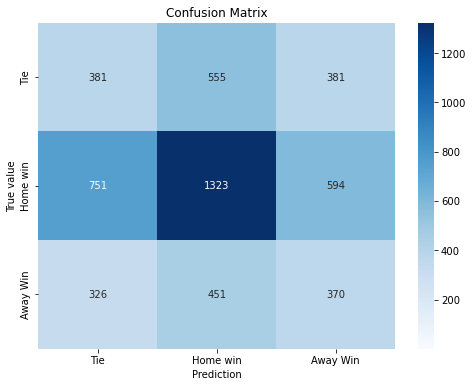

In [179]:
#Print Confusion Matrix
## PONER EN Y_pred el modelo que quieres!!
cm = confusion_matrix(y_test, y_pred_rf)
labels = ['Tie', 'Home win', 'Away Win']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2)
plt.title('Confusion Matrix')
plt.ylabel('True value')
plt.xlabel('Prediction')
plt.show()

## True result, well prediction, bad pred

In [180]:
index= X_test.index
df_pred= df_aux.loc[index]
df_pred['prediction'] = y_pred_rf
columns= ['season','division','matchday','date','home_team','away_team','Result','prediction']
df_pred= df_pred[columns]

In [181]:
result = df_pred['Result'].value_counts()
pred= df_pred[['prediction','Result']]
good_pred= pred[pred['prediction'] == pred['Result']].value_counts()
good_pred.reset_index(drop=True, inplace=True, level='Result')

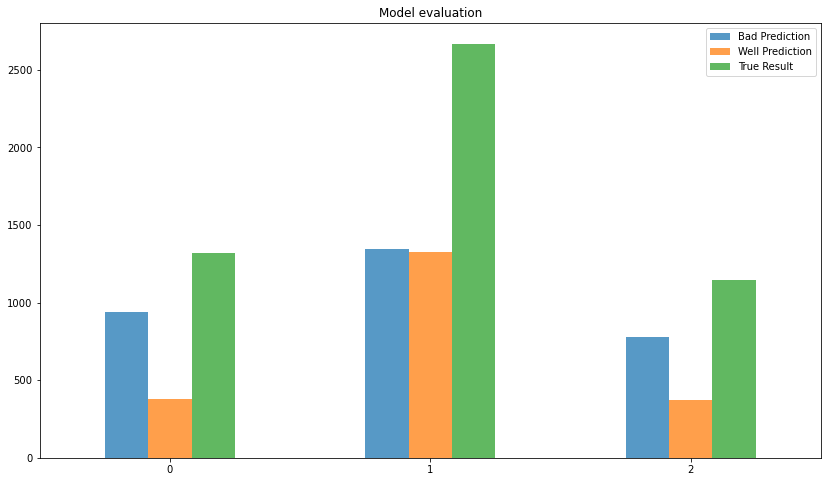

In [182]:
bad_pred= pred[(pred['prediction'] != pred['Result'])].groupby('Result').count()
bad_pred= bad_pred['prediction']
evaluation= pd.concat([bad_pred, good_pred,result], axis=1, keys=['Bad Prediction','Well Prediction','True Result']).plot(kind='bar',
            figsize=(14,8),
            title="Model evaluation",alpha=0.75, rot=0)


## Analysis of failures and successes

Result        0     1    2
prediction                
0           381   751  326
1           555  1323  451
2           381   594  370


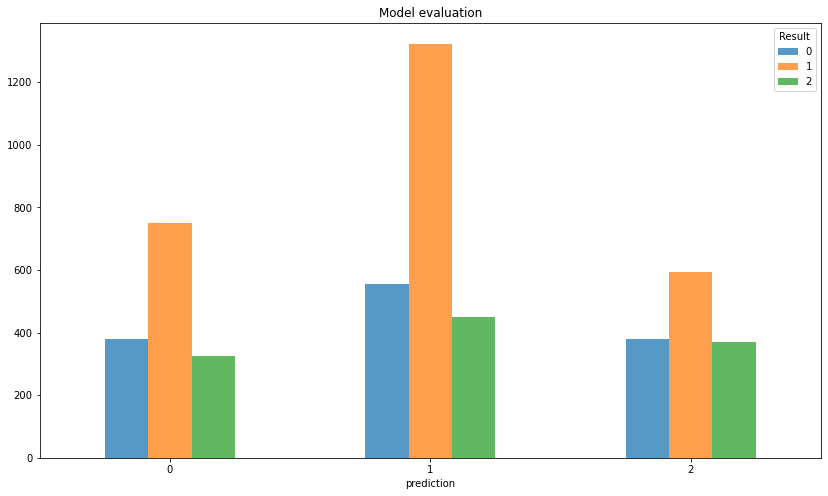

In [183]:
fail_suc= pred[(pred['prediction'] != pred['Result']) | (pred['prediction'] == pred['Result']) ].value_counts()
fail_suc= pd.DataFrame(fail_suc)
fail_suc = fail_suc.unstack()
fail_suc[0].plot(kind='bar',
            figsize=(14,8),
            title="Model evaluation",alpha=0.75, rot=0)

print(fail_suc[0])


# EXPORT MODEL

This only exports the last model run and the TEST

In [184]:
#Replace 0 with X
df_pred[['Result','prediction']] = df_pred[['Result','prediction']].astype(str) 
df_pred[['Result','prediction']]= df_pred[['Result','prediction']].replace('0','X')

shouldExport = input('Do you want to export the model(s) (y / n) ? ')
if shouldExport.strip().lower() == 'y':
    df_pred.to_excel("../models/Predictions.xlsx")